In [2]:
# Libraries
import gym
import numpy as np
from collections import deque
from tqdm import tqdm

# Agents
from CarRacingAgents import CarRacingAgent01, CarRacingAgent02, CarRacingAgent03

# Plots
from CarRacingPlots import plot_performance, plot_episode_duraton, plot_epsilon

# Set Experiment - Car Racing
Set the experiment for Car Racing Environment

In [2]:
# Run experiment
def run_experiment(
    environment,
    agent,
    render = False,
    num_episodes = 300,
    skip_frames = 2,
    training_batch_size = 32, #64
    save_training_frequency = 50,
    update_target_model_frequency = 5,
    model = None, # Use pretrained model
):

    # Load model
    if model:
        agent.load(model)

    for episode in tqdm(range(1, num_episodes+1)):
        
        # Reset Environment
        init_state = environment.reset()

        # Process State
        init_state = agent.process_state_image(init_state, env)

        total_reward = 0
        negative_reward_counter = 0
        state_frame_stack_queue = deque([init_state]*agent.frame_stack_num, maxlen=agent.frame_stack_num)
        time_frame_counter = 1
        done = False
        
        while True:
            if render:
                env.render()

            current_state_frame_stack = agent.generate_state_frame_stack_from_queue(state_frame_stack_queue)
            action = agent.act(current_state_frame_stack)

            reward = 0
            for _ in range(skip_frames+1):
                next_state, r, done, _ = env.step(action)
                reward += r
                if done:
                    break

            # If continually getting negative reward 10 times after the tolerance steps, terminate this episode
            negative_reward_counter = negative_reward_counter + 1 if time_frame_counter > 100 and reward < 0 else 0

            total_reward += reward

            next_state = agent.process_state_image(next_state, env)
            state_frame_stack_queue.append(next_state)
            next_state_frame_stack = agent.generate_state_frame_stack_from_queue(state_frame_stack_queue)

            agent.memorize(current_state_frame_stack, action, reward, next_state_frame_stack, done)

            if done or negative_reward_counter >= 25 or total_reward < 0:
                #print('Episode: {}/{}, Scores(Time Frames): {}, Total Rewards(adjusted): {:.2}, Epsilon: {:.2}'.format(episode, num_episodes, time_frame_counter, float(total_reward), float(agent.epsilon)))
                agent.results.append(total_reward)
                agent.epsilons.append(agent.epsilon)
                agent.episode_durations.append(time_frame_counter)
                break

            if len(agent.memory) > training_batch_size:
                agent.replay(training_batch_size)
            time_frame_counter += 1

        if episode % update_target_model_frequency == 0:
            agent.update_target_model()

        if episode % save_training_frequency == 0:
            agent.save(f'./trained_agents/{agent.name}__{episode}.h5')
            np.save(f'./trained_agents/{agent.name}__{episode}', agent.results)

    if render:
        env.close()

    return agent

## Train Agent 01: DNN (Sensors)

In [12]:
# Set agent and envronment
env = gym.make('CarRacing-v1', continuous=False)
agent = CarRacingAgent01(epsilon=0.5, epsilon_min = 0, epsilon_decay = 0.99996, learning_rate = 0.0002, gamma = 0.95, hidden_neurons = 64)

# Run Experiment
agent_albon = run_experiment(env, agent, num_episodes = 1000,  training_batch_size = 4,)

100%|██████████| 1000/1000 [8:11:26<00:00, 29.49s/it]  


C:\Users\carlo\AppData\Roaming\Python\Python39\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


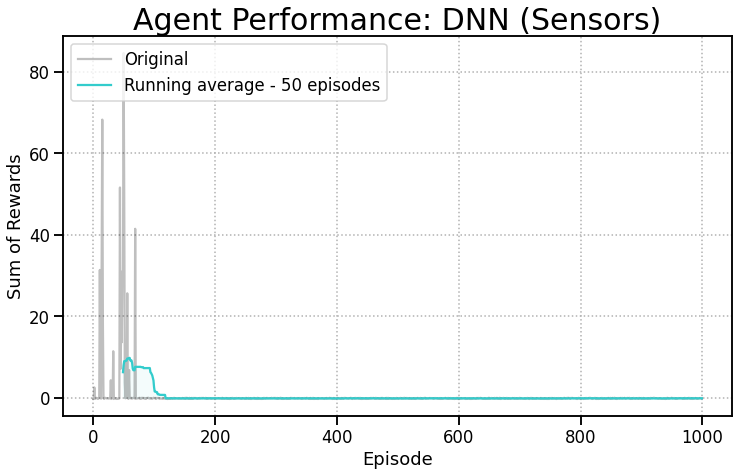

C:\Users\carlo\AppData\Roaming\Python\Python39\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


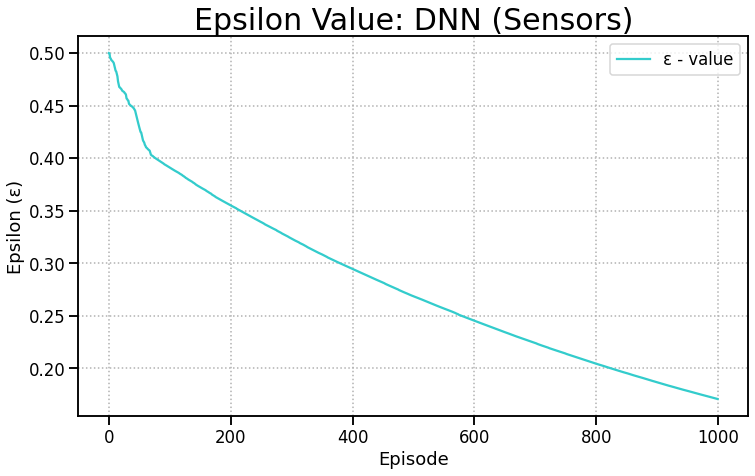

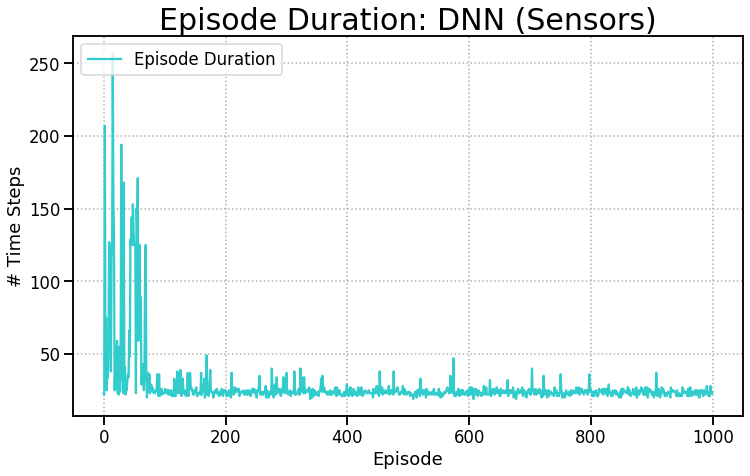

In [41]:
# Plot Results
plot_performance(agent_albon.results, title = 'Agent Performance: DNN (Sensors)')
plot_epsilon(agent_albon.epsilons, title = 'Epsilon Value: DNN (Sensors)')
plot_episode_duraton(agent_albon.episode_durations, title = 'Episode Duration: DNN (Sensors)')

## Train Agent 02: CNN

In [19]:
# Set agent and envronment
env = gym.make('CarRacing-v1', continuous=False)
agent = CarRacingAgent02(epsilon=1.0, epsilon_min = 0, epsilon_decay = 0.99995, learning_rate = 0.0005)

# Run Experiment
agent_bottas = run_experiment(env, agent, num_episodes = 500, training_batch_size = 32)

100%|██████████| 500/500 [7:04:21<00:00, 50.92s/it]  


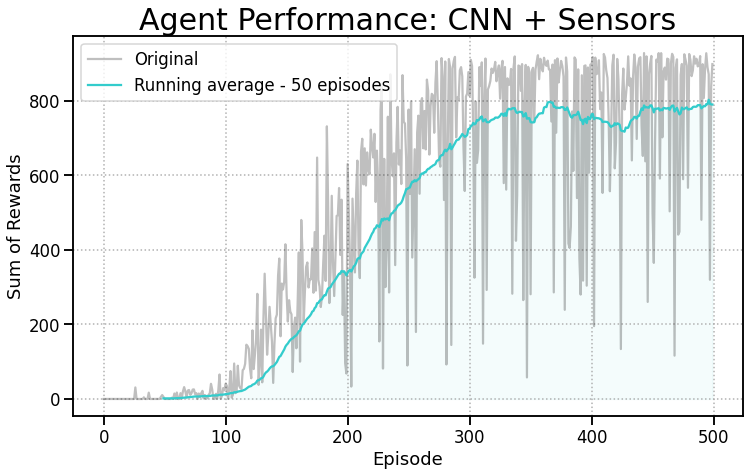

C:\Users\carlo\AppData\Roaming\Python\Python39\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


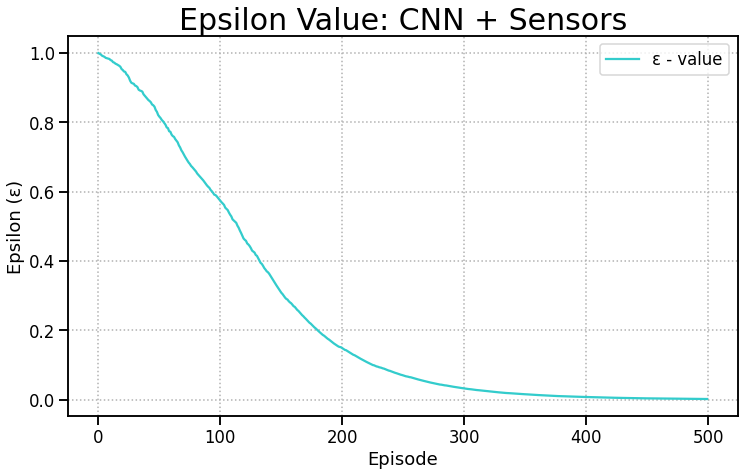

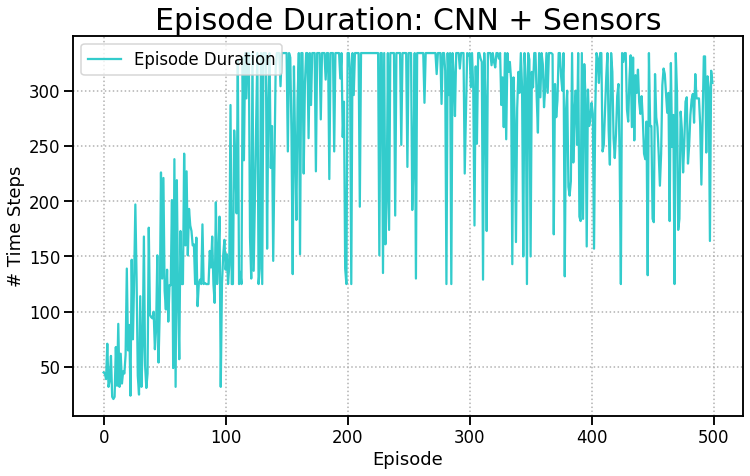

In [20]:
# Plot Results
plot_performance(agent_bottas.results, title = 'Agent Performance: CNN')
plot_epsilon(agent_bottas.epsilons, title = 'Epsilon Value: CNN')
plot_episode_duraton(agent_bottas.episode_durations, title = 'Episode Duration: CNN + Sensors')

## Train Agent 03: CNN + Sensors

In [21]:
# Set agent and envronment
env = gym.make('CarRacing-v1', continuous=False)
agent = CarRacingAgent03(epsilon=1.0, epsilon_min = 0, epsilon_decay = 0.99995, learning_rate = 0.0005)

# Run Experiment
agent_norris = run_experiment(env, agent, num_episodes = 500, training_batch_size = 32)

100%|██████████| 500/500 [7:34:00<00:00, 54.48s/it]  


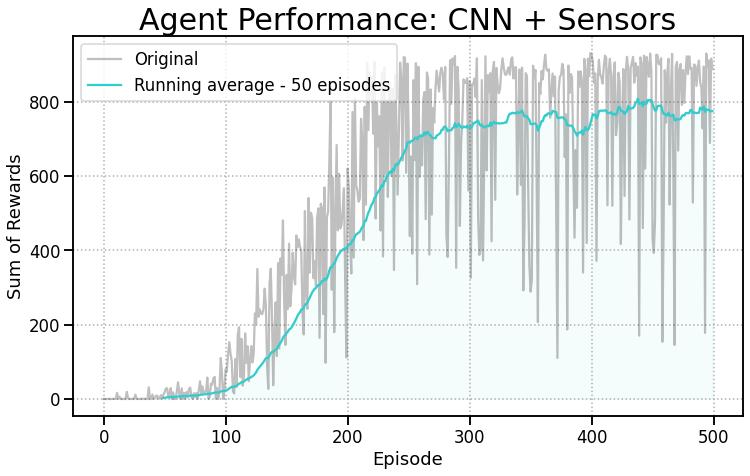

C:\Users\carlo\AppData\Roaming\Python\Python39\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


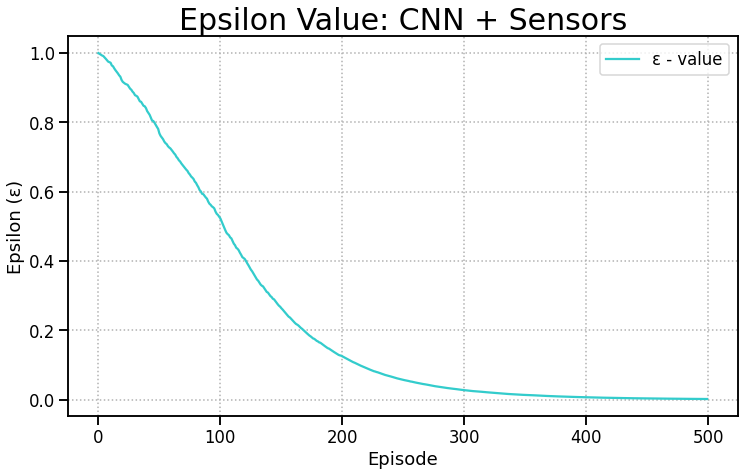

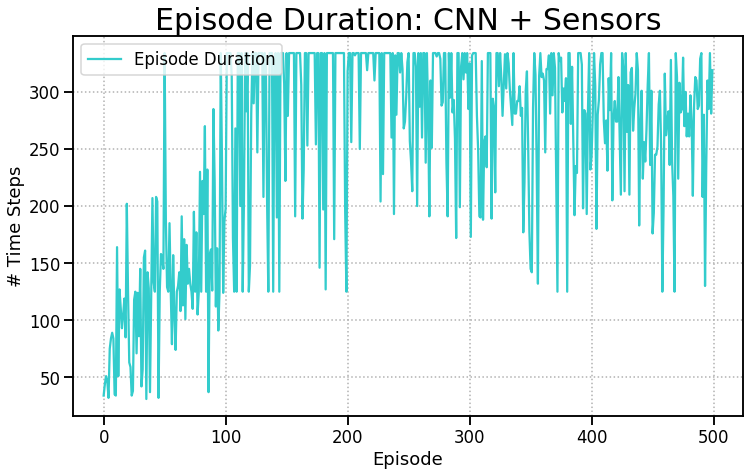

In [22]:
# Plot Results
plot_performance(agent_norris.results, title = 'Agent Performance: CNN + Sensors')
plot_epsilon(agent_norris.epsilons, title = 'Epsilon Value: CNN + Sensors')
plot_episode_duraton(agent_norris.episode_durations, title = 'Episode Duration: CNN + Sensors')

In [17]:
# Test

# Set agent and envronment
env = gym.make('CarRacing-v1', continuous=False)
agent = CarRacingAgent02(epsilon=0.1, epsilon_min = 0, epsilon_decay = 0.99991, learning_rate = 1e-4, name = 'agent_03v2')

# Run Experiment
agent_bottas = run_experiment(env, agent, num_episodes = 200, training_batch_size = 1024, model='trained_agents/agent_02__500.h5', render = False)

# 100%|██████████| 200/200 [3:02:04<00:00, 54.62s/it]  <-- I believe batch size was 2/4/8

100%|██████████| 200/200 [3:02:04<00:00, 54.62s/it]  


C:\Users\carlo\AppData\Roaming\Python\Python39\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


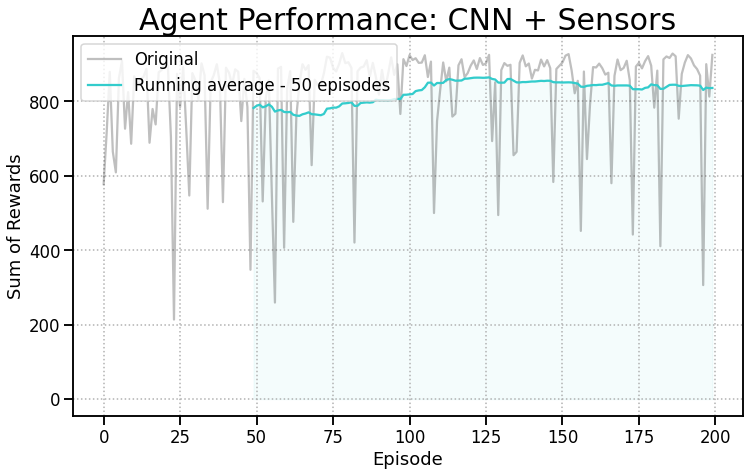

C:\Users\carlo\AppData\Roaming\Python\Python39\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


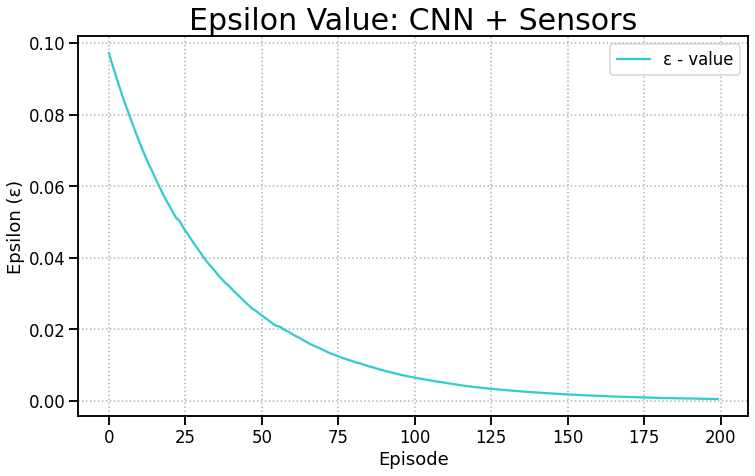

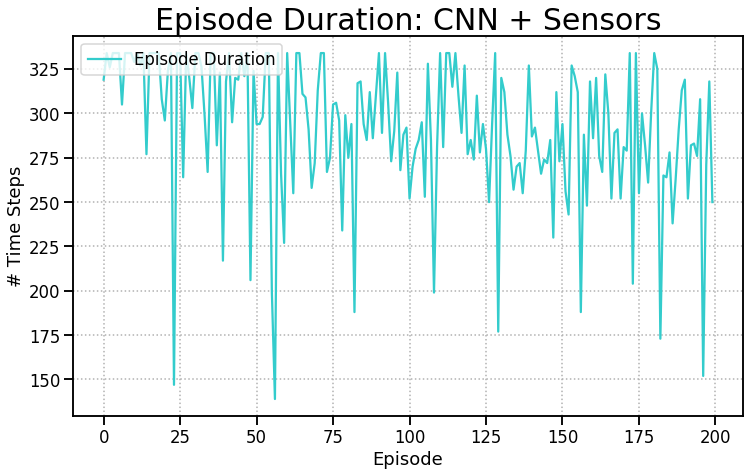

In [19]:
# Plot Results
plot_performance(agent_bottas.results, title = 'Agent Performance: CNN + Sensors')
plot_epsilon(agent_bottas.epsilons, title = 'Epsilon Value: CNN + Sensors')
plot_episode_duraton(agent_bottas.episode_durations, title = 'Episode Duration: CNN + Sensors')

In [6]:
# Test

# Set agent and envronment
env = gym.make('CarRacing-v1', continuous=False)
agent = CarRacingAgent03(epsilon=0.1, epsilon_min = 0, epsilon_decay = 0.99991, learning_rate = 1e-4, name = 'agent_03v3')

# Run Experiment
agent_norris = run_experiment(env, agent, num_episodes = 200, training_batch_size = 4, model='trained_agents/agent_03__500.h5', render = False)

100%|██████████| 200/200 [3:24:19<00:00, 61.30s/it]  


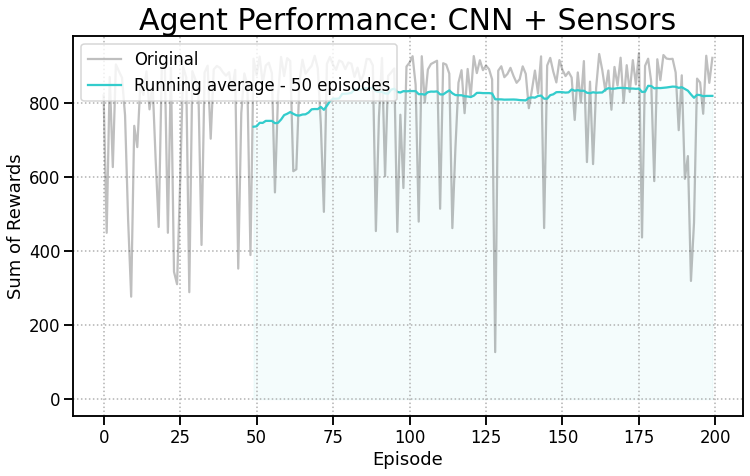

C:\Users\carlo\AppData\Roaming\Python\Python39\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


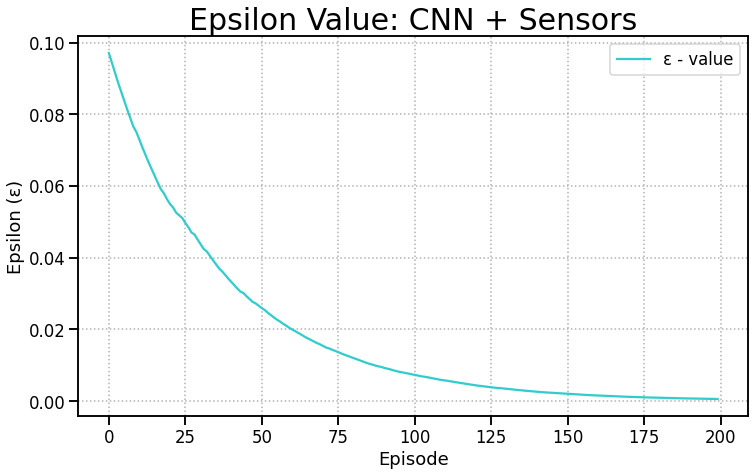

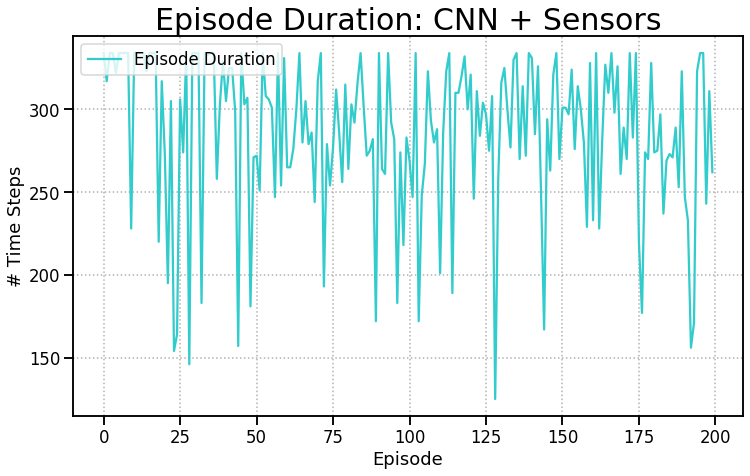

In [7]:
# Plot Results
plot_performance(agent_norris.results, title = 'Agent Performance: CNN + Sensors')
plot_epsilon(agent_norris.epsilons, title = 'Epsilon Value: CNN + Sensors')
plot_episode_duraton(agent_norris.episode_durations, title = 'Episode Duration: CNN + Sensors')

## Test Agents

In [16]:
from matplotlib import animation
import matplotlib.pyplot as plt
import gym 


def save_frames_as_gif(frames, path='./agent_gifs/', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50);
    anim.save(path + filename, writer='imagemagick', fps=50);

In [17]:
render = True
seed_nums = [32, 45, 46, 83, 123, 934, 563, 1023, 27546, 32450]
time_steps = 1000

In [18]:
agent_max = CarRacingAgent03(name = 'agent_max')
agent_max.load('trained_agents/agent_03v3__200.h5')

0it [00:00, ?it/s]MovieWriter imagemagick unavailable; using Pillow instead.
1it [01:42, 102.01s/it]MovieWriter imagemagick unavailable; using Pillow instead.
2it [03:23, 101.50s/it]MovieWriter imagemagick unavailable; using Pillow instead.
3it [05:05, 101.92s/it]MovieWriter imagemagick unavailable; using Pillow instead.
4it [06:44, 100.84s/it]MovieWriter imagemagick unavailable; using Pillow instead.
5it [08:25, 100.68s/it]MovieWriter imagemagick unavailable; using Pillow instead.
6it [10:07, 101.12s/it]MovieWriter imagemagick unavailable; using Pillow instead.
7it [11:49, 101.68s/it]MovieWriter imagemagick unavailable; using Pillow instead.
8it [13:38, 103.89s/it]MovieWriter imagemagick unavailable; using Pillow instead.
9it [15:20, 103.19s/it]MovieWriter imagemagick unavailable; using Pillow instead.
10it [17:02, 102.20s/it]

Results: [879.66, 893.63, 867.32, 881.82, 856.52, 823.08, 875.0, 772.61, 873.58, 882.14]. 
 Avg: 860.5360000000001


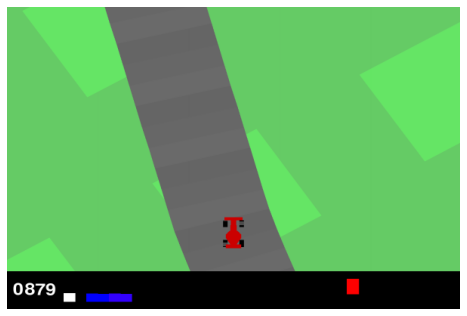

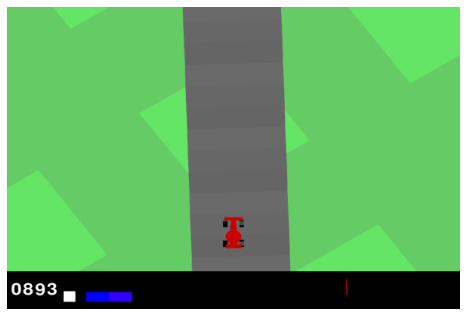

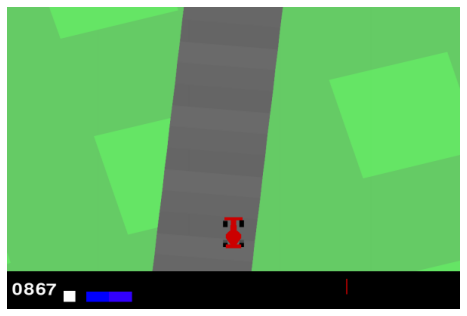

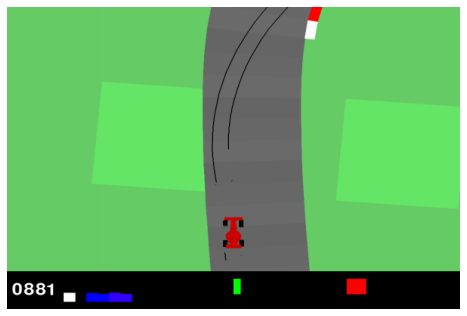

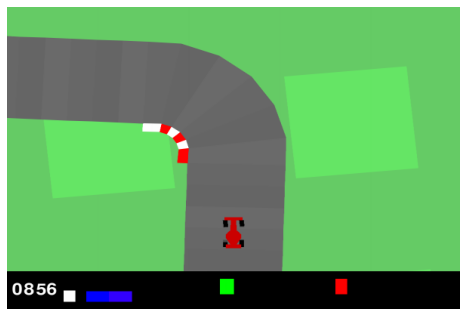

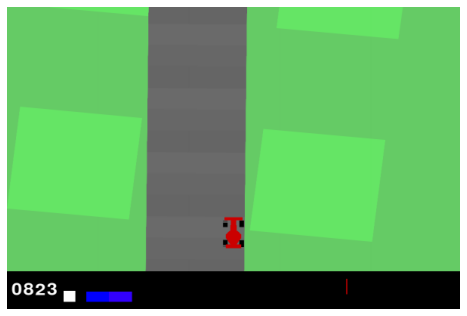

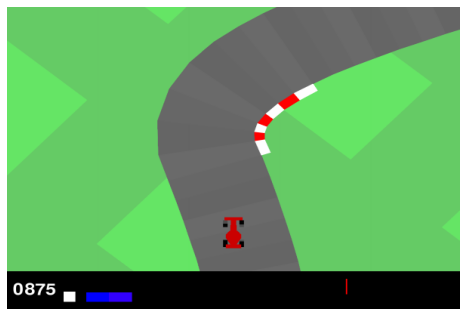

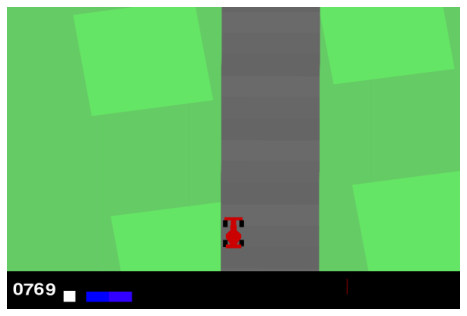

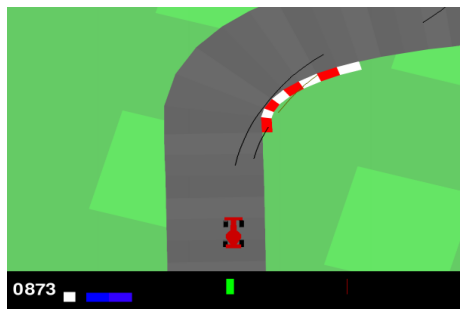

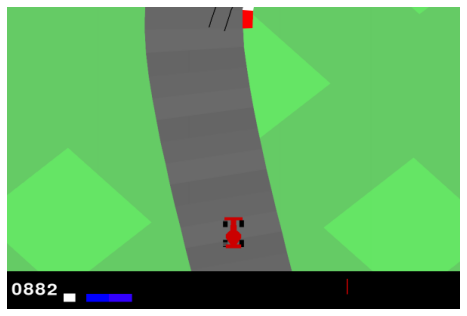

In [19]:
# Set agent to tets
agent = agent_max
agent.epsilon = 0 # Set epsilon to 0

scores = []
env = gym.make('CarRacing-v1', continuous=False)

for e, seed_num in tqdm(enumerate(seed_nums)):
    init_state = env.reset(seed=seed_num)
    init_state = agent.process_state_image(init_state, env)

    total_reward = 0
    punishment_counter = 0
    state_frame_stack_queue = deque([init_state]*agent.frame_stack_num, maxlen=agent.frame_stack_num)

    frames = []
    
    for i in range(time_steps):
        
        if render:
            #env.render()
            frames.append(env.render(mode="rgb_array"))

        current_state_frame_stack = agent.generate_state_frame_stack_from_queue(state_frame_stack_queue)
        action = agent.act(current_state_frame_stack)
        next_state, reward, done, info = env.step(action)

        total_reward += reward

        next_state = agent.process_state_image(next_state, env)
        state_frame_stack_queue.append(next_state)

        if done:
            #print(f'Reward: {round(total_reward,2)}')
            scores.append(round(total_reward,2))
            break

    save_frames_as_gif(frames, filename=f'{agent.name}__{seed_num}.gif')

if render:
    env.close()

print(f"Results: {scores}. \n Avg: {np.mean(scores)}")


In [9]:
# Set agent to tets
agent = agent_norris
agent.epsilon = 0 # Set epsilon to 0

scores = []
env = gym.make('CarRacing-v1', continuous=False)

for e, seed_num in tqdm(enumerate(seed_nums)):
    init_state = env.reset(seed=seed_num)
    init_state = agent.process_state_image(init_state, env)

    total_reward = 0
    punishment_counter = 0
    state_frame_stack_queue = deque([init_state]*agent.frame_stack_num, maxlen=agent.frame_stack_num)
    
    for i in range(time_steps):
        
        if render:
            env.render()

        current_state_frame_stack = agent.generate_state_frame_stack_from_queue(state_frame_stack_queue)
        action = agent.act(current_state_frame_stack)
        next_state, reward, done, info = env.step(action)

        total_reward += reward

        next_state = agent.process_state_image(next_state, env)
        state_frame_stack_queue.append(next_state)

        if done:
            #print(f'Reward: {round(total_reward,2)}')
            scores.append(round(total_reward,2))
            break

if render:
    env.close()

print(f"Results: {scores}. \n Avg: {np.mean(scores)}")

10it [11:04, 66.41s/it]

Results: [879.66, 893.63, 867.32, 881.82, 856.52, 823.08, 875.0, 772.61, 873.58, 882.14]. 
 Avg: 860.5360000000001


In [21]:
# Set agent to tets
agent = agent_bottas
agent.epsilon = 0 # Set epsilon to 0

scores = []
env = gym.make('CarRacing-v1', continuous=False)

for e, seed_num in tqdm(enumerate(seed_nums)):
    init_state = env.reset(seed=seed_num)
    init_state = agent.process_state_image(init_state, env)

    total_reward = 0
    punishment_counter = 0
    state_frame_stack_queue = deque([init_state]*agent.frame_stack_num, maxlen=agent.frame_stack_num)
    
    for i in range(time_steps):
        
        if render:
            env.render()

        current_state_frame_stack = agent.generate_state_frame_stack_from_queue(state_frame_stack_queue)
        action = agent.act(current_state_frame_stack)
        next_state, reward, done, info = env.step(action)

        total_reward += reward

        next_state = agent.process_state_image(next_state, env)
        state_frame_stack_queue.append(next_state)

        if done:
            #print(f'Reward: {round(total_reward,2)}')
            scores.append(round(total_reward,2))
            break

if render:
    env.close()

print(f"Results: {scores}. \n Avg: {np.mean(scores)}")

10it [09:04, 54.49s/it]

Results: [784.75, 845.86, 880.39, 915.6, 769.57, 826.42, 864.29, 858.6, 926.7, 892.86]. 
 Avg: 856.5040000000001


In [24]:
# Set agent to tets
agent = agent_bottas
agent.epsilon = 0 # Set epsilon to 0

scores = []
env = gym.make('CarRacing-v1', continuous=False)

for e, seed_num in tqdm(enumerate(seed_nums)):
    init_state = env.reset(seed=seed_num)
    init_state = agent.process_state_image(init_state, env)

    total_reward = 0
    punishment_counter = 0
    state_frame_stack_queue = deque([init_state]*agent.frame_stack_num, maxlen=agent.frame_stack_num)
    
    for i in range(time_steps):
        
        if render:
            env.render()

        current_state_frame_stack = agent.generate_state_frame_stack_from_queue(state_frame_stack_queue)
        action = agent.act(current_state_frame_stack)
        next_state, reward, done, info = env.step(action)

        total_reward += reward

        next_state = agent.process_state_image(next_state, env)
        state_frame_stack_queue.append(next_state)

        if done:
            #print(f'Reward: {round(total_reward,2)}')
            scores.append(round(total_reward,2))
            break

if render:
    env.close()

print(f"Results: {scores}. \n Avg: {np.mean(scores)}")

10it [07:44, 46.48s/it]

Results: [889.83, 820.38, 880.39, 878.18, 831.68, 853.18, 860.71, 581.53, 884.91, 924.4]. 
 Avg: 840.5189999999999


In [4]:
# Set agent to tets
# agent = agent_norris
# agent.epsilon = 0 # Set epsilon to 0

agent_test = CarRacingAgent02()
agent_test.load('trained_agents/agent_02__500.h5')
agent = agent_test
agent.epsilon = 0 # Set epsilon to 0

scores = []
env = gym.make('CarRacing-v1', continuous=False)

for e, seed_num in tqdm(enumerate(seed_nums)):
    init_state = env.reset(seed=seed_num)
    init_state = agent.process_state_image(init_state, env)

    total_reward = 0
    punishment_counter = 0
    state_frame_stack_queue = deque([init_state]*agent.frame_stack_num, maxlen=agent.frame_stack_num)
    
    for i in range(time_steps):
        
        if render:
            env.render()

        current_state_frame_stack = agent.generate_state_frame_stack_from_queue(state_frame_stack_queue)
        action = agent.act(current_state_frame_stack)
        next_state, reward, done, info = env.step(action)

        total_reward += reward

        next_state = agent.process_state_image(next_state, env)
        state_frame_stack_queue.append(next_state)

        if done:
            #print(f'Reward: {round(total_reward,2)}')
            scores.append(round(total_reward,2))
            break

if render:
    env.close()

print(f"Results: {scores}. \n Avg: {np.mean(scores)}")

10it [09:11, 55.14s/it]

Results: [889.83, 820.38, 880.39, 878.18, 831.68, 853.18, 860.71, 581.53, 884.91, 924.4]. 
 Avg: 840.5189999999999
